#IMPORT LIBRARIES

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.model_selection import KFold
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.layers.embeddings import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Bidirectional
from contextlib import redirect_stdout
with redirect_stdout(open(os.devnull, "w")):             ### Silence download progressing by re-directing to stdout
   nltk.download('stopwords')
   nltk.download('punkt')
   nltk.download('averaged_perceptron_tagger')
   nltk.download('wordnet')
   from nltk.corpus import stopwords

### Importing data

In [ ]:
def importing(filename): 
  path = filename + ".txt"
  
  a_file = open(path, "r")
  words = []
  for line in a_file:
      stripped_line = line.strip()
      line_list = stripped_line
      words.append(line_list)
  a_file.close()
  DF = pd.DataFrame()
  DF[filename] = words
  return DF


# PREPROCESSING

## REMOVING STOPWORDS

In [ ]:
stop = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

In [ ]:
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

## LEMMATIZE

In [ ]:
#lemmatization 
def lemmatize_sentence(sentence):

    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    
    #tuple of (token, wordnet_tag)

    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

## REMOVING BLANK LINES

In [ ]:
def removing_lines(df):
  col = df.columns[0]
  df.dropna(inplace = True)
  df.drop([], inplace = True)
  df = df[~df[col].str.len().eq(0)]

  return df

## FINAL PREPROCESSING

In [ ]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = " "  
    
    # traverse in the string   
    for ele in s:  
        
        str1 += ele   
        str1+=' '

    
    # return string   
    return str1  

In [ ]:
# function to identify & remove unwanted characters from text in "Combined Description"

def preprocess(data):
    
    temp1 =[]
    col = data.columns[0]
    for sentence in data[col]:
        sentence = sentence.lower() #lower case
        cleanr = re.compile('<.*?>')
        sentence = re.sub(cleanr, ' ', sentence)        #removing HTML tags
        sentence = re.sub(r'\S+@\S+', 'EmailId', sentence)#removing mail ids
        sentence = re.sub(r'\S+@\S+', 'https', sentence)#removing https
        sentence = re.sub(r'\S+@\S+', 'http', sentence)#removing http
        sentence = re.sub(r'\'', '', sentence, re.I|re.A)
        sentence = re.sub(r'[0-9]', '', sentence, re.I|re.A)
        sentence = re.sub(r'[^a-zA-Z0-9\s]', ' ', sentence)
        sentence = sentence.lower()
        sentence = re.sub(r'com ', ' ', sentence, re.I|re.A)
        sentence = re.sub(r'Subject: ', ' ', sentence, re.I|re.A)
        sentence = re.sub(r'\[cid:(.*)]', ' ', sentence, re.I|re.A)
        sentence = re.sub(r'hello ', ' ', sentence, re.I|re.A)
        #sentence = re.sub(r'The information(.*)infection', ' ', sentence, re.I|re.A)  # footer
        #sentence = re.sub(r'Endava Limited is a company(.*)or omissions', ' ', sentence,  re.I|re.A)  # footer
        #sentence = re.sub(r'The information in this email is confidential and may be legally(.*)interference if you are not the intended recipient', ' ', sentence, re.I|re.A)  # footer
        #sentence = re.sub(r'select the following link to view the disclaimer in an alternate language.', ' ', sentence, re.I|re.A)  # disclaimer footer
        l_sentence = lemmatize_sentence(sentence)

        words = [word for word in l_sentence.split() if word not in stopwords.words('english')]
        temp1.append(words)
        
    temp = []
    for sentence in temp1:
      
      temp.append(listToString(sentence))
    data[col] = temp
    return data
    #print ("Sentence = ",sentence)

# WORD FREQUENCY

In [ ]:
def freq_words(x, terms = 30): 
    all_words = []
    #all_words.append([text for text in x])
    all_words = ' '.join([text for text in x]) 
    #[i.split() for i in all_words]
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 

    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 

    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()
    return d
# print 100 most frequent words

# WORDCLOUD

In [ ]:
# Python program to generate WordCloud 
def cloud(data):
      
    comment_words = '' 
    stopwords = set(STOPWORDS) 
      
    # iterate through the csv file 
    for val in data: 
          
        # typecaste each val to string 
        val = str(val) 
      
        # split the value 
        tokens = val.split() 
          
        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
          
        comment_words += " ".join(tokens)+" "
      
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 
      
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
      
    plt.show() 

# BI GRAMS

In [ ]:
def bi_gram(data):
  word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
  sparse_matrix = word_vectorizer.fit_transform(data)
  frequencies = sum(sparse_matrix).toarray()[0]
  bi_grams_df = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
  print(bi_grams_df.sort_values(by = "frequency",ascending=False).head(5))


# TOKENIZE

In [ ]:
def get_all_words(df):
  col = df.columns[0]
  all_words = list()
  for w in df[col]:
      all_words.append(w)
  vocab_size = len(set(all_words))  # There are 6655 words in total
  print('Size of vocabulary: {}'.format(len(set(all_words))))
  return all_words

In [ ]:
def token(df):
  col = df.columns[0]
  vocab_size = len(set(all_words))
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
  tokenizer.fit_on_texts(df[col])
  X = tokenizer.texts_to_sequences(df[col])
  X = pad_sequences(X, maxlen = len(set(all_words)))
  y = np.asarray(df[col])

  print("Number of Samples:", len(X))
  print(X[1])
  print("Number of Labels: ", len(y))
  print(y[1])
  return X

# LABEL ENCODE

In [ ]:
def labelencoding(df):
  col = df.columns[1]
  encoder = preprocessing.LabelEncoder()
  Y = encoder.fit_transform(df[col])
  labelclasses = [0,1,2]
  actual = encoder.inverse_transform(labelclasses)
  print('The labels or each class are as follows:')
  for i in labelclasses:
    print(labelclasses[i], actual[i])
  return Y

# PIPELINE (FOR TRAIN DATA)

## IMPORTING PIPELINE

In [ ]:
drugs = importing('drugs')
miso = importing('misogyny')
violence = importing('violence')

In [ ]:
drugs.head()

,drugs
0,I drink I smoke
1,Bitch I go harder sippin on patron till it tas...
2,I drink I smoke
3,And who the fuck care smoking on this kush til...
4,I drink I smoke


In [ ]:
miso.head()

,misogyny
0,Turn around bitch I got a use for you
1,Besides you ain't got nothin' better to do
2,
3,Annie's twelve years old in two more she'll be...
4,


In [ ]:
violence.head()

,violence
0,You and your husband have a fight/One of you t...
1,
2,Plucked you like a chicken wit' your head cut ...
3,
4,Dumped her body in the trash like I never knew...


In [ ]:
df = pd.DataFrame()
df['text'] = miso['misogyny']
df['labels'] = 'misogyny'

df2 = pd.DataFrame()
df2['text'] = drugs['drugs']
df2['labels'] = 'drugs'

df = df.append(df2 , ignore_index=True)


df3 = pd.DataFrame()
df3['text'] = violence['violence']
df3['labels'] = 'violence'
df = df.append(df3 , ignore_index=True)


##PREPROCESSING PIPELINE

In [ ]:
df = removing_lines(df)
df = preprocess(df)


drugs = preprocess(drugs)
miso = preprocess(miso)
violence = preprocess(violence)

## VISUALIZATIONS PIPELINE

In [ ]:
bi_gram(miso['misogyny'])
bi_gram(drugs['drugs'])
bi_gram(violence['violence'])


            frequency
bitch aint          5
even know           4
aint shit           4
aint even           3
save phone          2
             frequency
im stoner           10
smoke two            7
stoner im            7
drink smoke          6
two joint            6
                  frequency
fo fun                    4
murder fo                 4
man murder                3
get ta                    3
accidentally get          2


Misogyny:


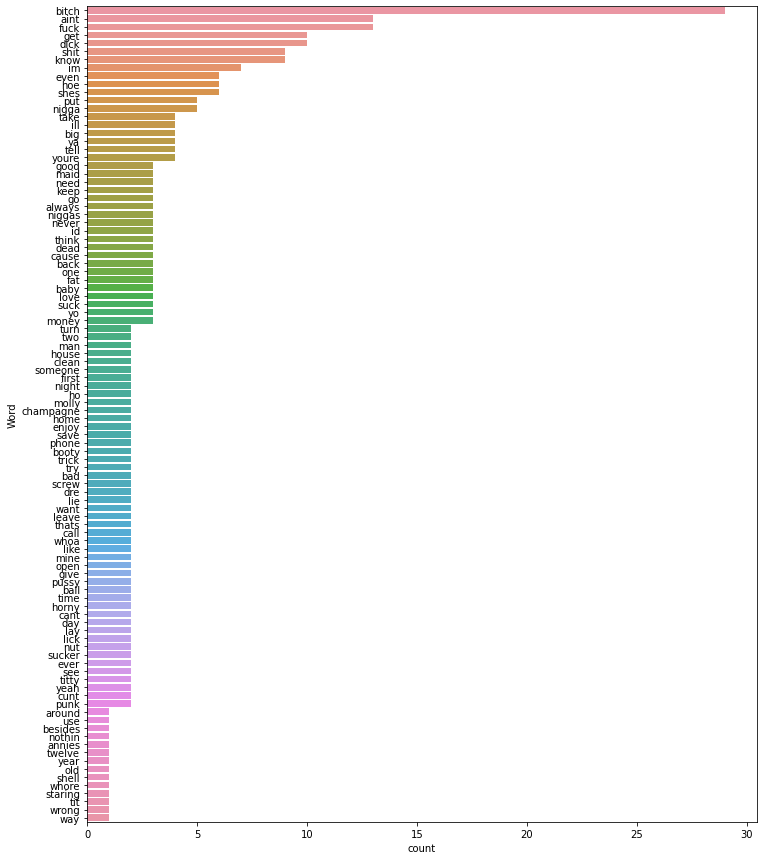

Drugs:


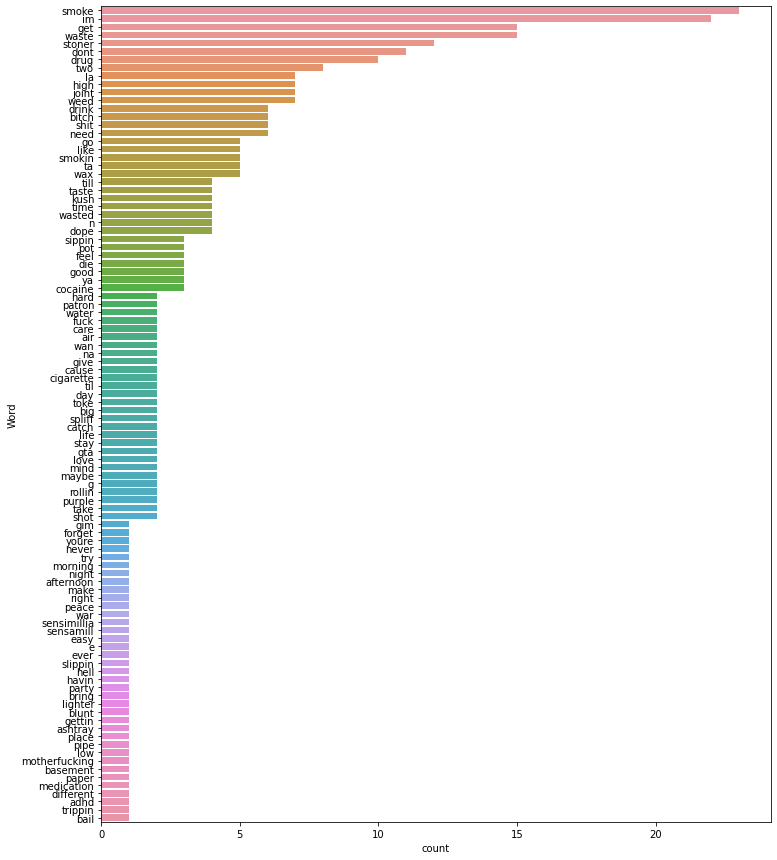

Violence:


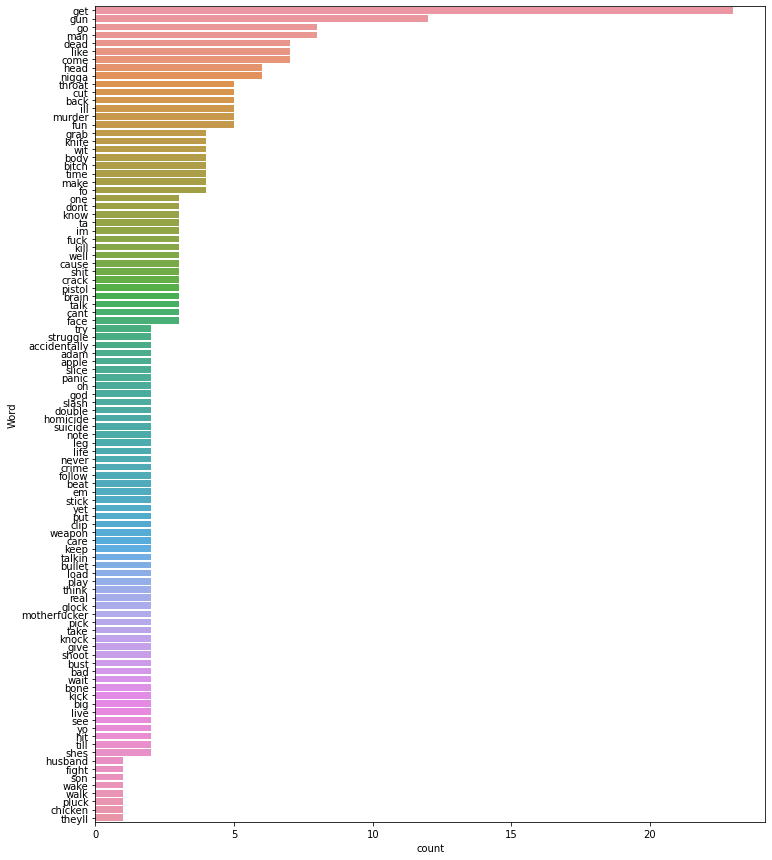

In [ ]:
print("Misogyny:")
d = freq_words(miso['misogyny'], 100)
print("Drugs:")
e = freq_words(drugs['drugs'], 100)
print("Violence:")
f = freq_words(violence['violence'], 100)

## TOKENIZATION

In [ ]:
all_words = get_all_words(df)
X = token(df)

Size of vocabulary: 240
Number of Samples: 263
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0

## LABEL ENCODING

In [ ]:
Y = labelencoding(df)

The labels or each class are as follows:
0 drugs
1 misogyny
2 violence


## TRAIN TEST SPLIT

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(210, 240) (210,)
(53, 240) (53,)


# MODEL

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 240, 128)          30720     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 240, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 3)                 591       
Total params: 286,111
Trainable params: 286,111
Non-trainable params: 0
_________________________________________________________________
None


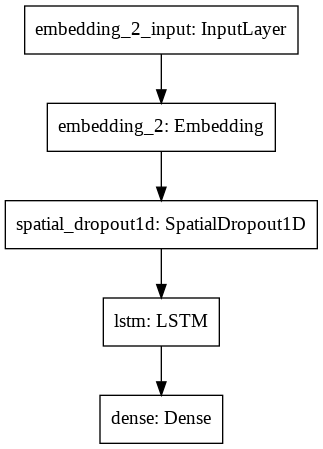

In [ ]:
embed_dim = 128
lstm_out = 196
Embedding(len(set(all_words)), 32, input_length= len(set(all_words)))
model = Sequential()
model.add(Embedding(len(set(all_words)),embed_dim,input_length = len(set(all_words))))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

#FIT DATA ON MODEL

In [ ]:
batch_size = 32
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), shuffle = True,  epochs = 20, batch_size= 50, verbose = 2)

Epoch 1/20
5/5 - 4s - loss: 1.0284 - accuracy: 0.4333 - val_loss: 1.0137 - val_accuracy: 0.5094
Epoch 2/20
5/5 - 4s - loss: 1.0120 - accuracy: 0.5190 - val_loss: 1.0073 - val_accuracy: 0.5849
Epoch 3/20
5/5 - 4s - loss: 0.9927 - accuracy: 0.5190 - val_loss: 0.9730 - val_accuracy: 0.4906
Epoch 4/20
5/5 - 4s - loss: 0.9838 - accuracy: 0.4810 - val_loss: 0.9554 - val_accuracy: 0.6038
Epoch 5/20
5/5 - 4s - loss: 0.9275 - accuracy: 0.6571 - val_loss: 0.9578 - val_accuracy: 0.5660
Epoch 6/20
5/5 - 4s - loss: 0.8916 - accuracy: 0.7762 - val_loss: 0.9001 - val_accuracy: 0.6792
Epoch 7/20
5/5 - 4s - loss: 0.8375 - accuracy: 0.7048 - val_loss: 0.8559 - val_accuracy: 0.6415
Epoch 8/20
5/5 - 4s - loss: 0.7692 - accuracy: 0.7524 - val_loss: 0.8102 - val_accuracy: 0.7170
Epoch 9/20
5/5 - 4s - loss: 0.6681 - accuracy: 0.8238 - val_loss: 0.7413 - val_accuracy: 0.7547
Epoch 10/20
5/5 - 4s - loss: 0.5714 - accuracy: 0.8476 - val_loss: 0.6831 - val_accuracy: 0.7736
Epoch 11/20
5/5 - 4s - loss: 0.5114 - a

# MODEL EVALUATION

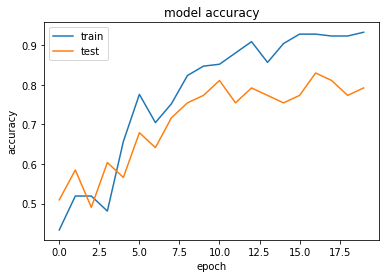

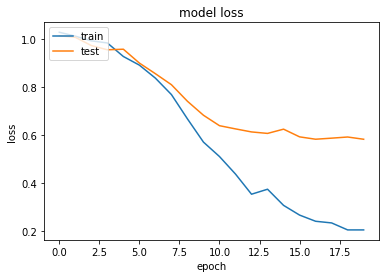

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
print(metrics.classification_report (Y_test, np.argmax(Y_pred, axis = 1),zero_division=1,target_names=np.unique(encoder.inverse_transform(Y_test))))

NameError: ignored

In [ ]:
Y_pred = model.predict(X_test, verbose=0)
Y_pred

array([[5.06846666e-01, 3.66994292e-01, 1.26159027e-01],
       [9.86846507e-01, 1.38011441e-04, 1.30155208e-02],
       [1.00033022e-01, 7.79470801e-01, 1.20496206e-01],
       [5.58663896e-06, 1.91036344e-03, 9.98084068e-01],
       [2.64109694e-03, 9.45990026e-01, 5.13689555e-02],
       [6.81873783e-02, 5.47974147e-02, 8.77015173e-01],
       [7.24365473e-01, 1.50414884e-01, 1.25219598e-01],
       [5.62355388e-04, 4.12127018e-01, 5.87310672e-01],
       [1.74832731e-01, 4.03573811e-02, 7.84809947e-01],
       [7.67937899e-02, 8.37283134e-01, 8.59231427e-02],
       [1.04674678e-02, 9.70982611e-01, 1.85498670e-02],
       [3.40166651e-02, 9.12971437e-01, 5.30118421e-02],
       [1.09253846e-01, 7.83037126e-01, 1.07708946e-01],
       [1.38476095e-03, 8.34912211e-02, 9.15124059e-01],
       [9.53681692e-02, 8.13203573e-01, 9.14282799e-02],
       [1.17750220e-01, 8.08503330e-02, 8.01399469e-01],
       [7.91541338e-02, 7.62773931e-01, 1.58071905e-01],
       [2.97146231e-01, 5.26768

In [ ]:
predictions = []
for i in range (len(Y_pred)):
  for j in range (3):
      if (Y_pred[i][j] == Y_pred[i].max()):
        predictions.append(j)
predictions = np.array(predictions)

In [ ]:
print(Y_test)
print(predictions)

[1 0 2 2 1 2 0 2 1 1 1 1 1 2 0 2 1 1 2 1 0 0 1 2 1 0 1 1 0 1 1 0 2 0 1 0 1
 2 0 1 0 1 1 1 1 0 0 1 1 0 0 0 1]
[0 0 1 2 1 2 0 2 2 1 1 1 1 2 1 2 1 1 2 0 0 0 1 1 1 0 1 2 0 1 2 0 2 0 1 1 1
 1 0 1 0 1 1 0 1 0 0 1 1 0 0 0 1]


In [ ]:
thresholds = []
for i in range (len(Y_pred)):
  for j in range (3):
      if (Y_pred[i][j] >= 0.4):
        thresholds.append(j)
      else:
        thresholds.append(9)
thresholds = np.array(thresholds)

In [ ]:
thresholds = []
flag = 0
for i in range (len(Y_pred)):
  for j in range (3):
      if (Y_pred[i][j] >= 0.5):
        thresholds.append(j)
        flag = 1
      
  if (flag==0):
    thresholds.append(9)
  flag = 0
thresholds = np.array(thresholds)

In [ ]:
thresholds

array([0, 0, 1, 2, 1, 2, 0, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 9, 0, 0,
       1, 9, 1, 0, 1, 9, 0, 1, 2, 0, 2, 0, 1, 1, 1, 9, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1])

In [ ]:
Y_pred

# PIPELINE (FOR TESTING)

In [ ]:
testdf = importing('drugsong')
testdf = removing_lines(testdf)
testdf = preprocess(testdf)

In [ ]:
bi_gram(testdf['drugsong'])

             frequency
touch light          2
choke like           2
baby im              2
light chain          2
like hate            2


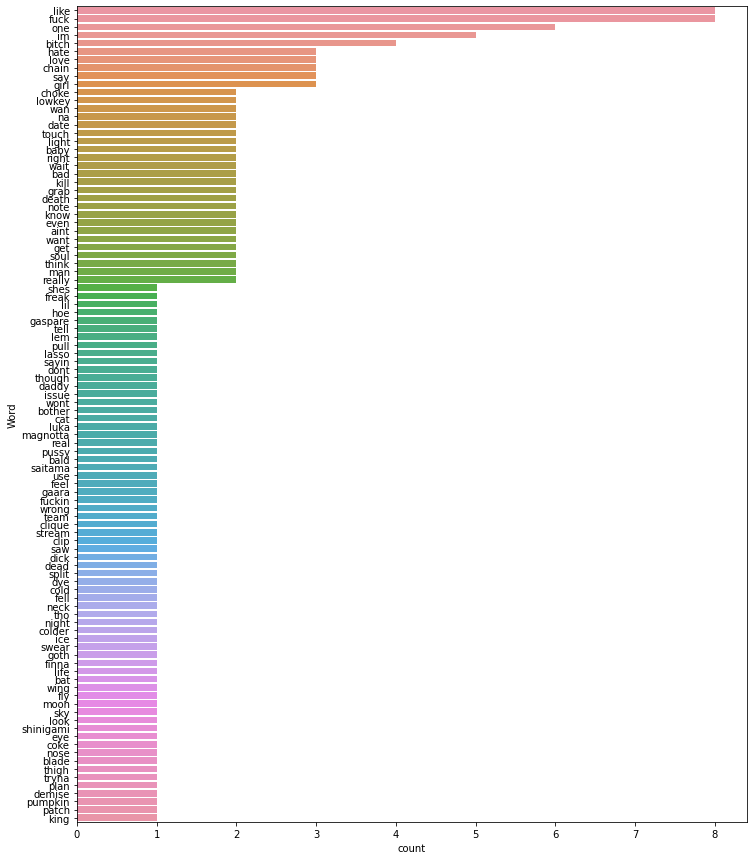

In [ ]:
e = freq_words(testdf['drugsong'], 100)

In [ ]:
testdf = preprocess(testdf)

In [ ]:
testdf.shape

(42, 1)

In [ ]:
all_words = get_all_words(testdf)
X = token(testdf)

Size of vocabulary: 36
Number of Samples: 42
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7]
Number of Labels:  42
 love 


# PREDICT NEW SONG

In [ ]:
Y_pred = model.predict(X, verbose=0)
Y_pred


array([[3.28633040e-01, 1.73477113e-01, 4.97889757e-01],
       [3.90063763e-01, 3.81713003e-01, 2.28223264e-01],
       [9.48041212e-03, 1.36564106e-01, 8.53955507e-01],
       [2.71938927e-02, 9.31238353e-01, 4.15677987e-02],
       [3.89942573e-03, 9.86340761e-01, 9.75976419e-03],
       [2.81514615e-01, 1.78672653e-02, 7.00618148e-01],
       [9.72414434e-01, 6.77714217e-03, 2.08083522e-02],
       [8.62594545e-01, 2.27751341e-02, 1.14630245e-01],
       [4.56399143e-01, 2.19351590e-01, 3.24249297e-01],
       [5.88738583e-02, 8.19837451e-01, 1.21288694e-01],
       [1.16522692e-01, 7.11525023e-01, 1.71952263e-01],
       [9.98865724e-01, 5.96963182e-05, 1.07460970e-03],
       [9.61715996e-01, 5.13174478e-03, 3.31522599e-02],
       [1.75987661e-03, 9.84615266e-01, 1.36247557e-02],
       [9.57917392e-01, 5.88542689e-03, 3.61972600e-02],
       [2.51650423e-01, 4.51052755e-01, 2.97296792e-01],
       [2.57530689e-01, 6.07595742e-01, 1.34873644e-01],
       [2.77955225e-03, 9.73413

In [ ]:
thresholds = []
flag = 0
for i in range (len(Y_pred)):
  for j in range (3):
      if (Y_pred[i][j] >= 0.7):
        thresholds.append(j)
        flag = 1
      
  if (flag==0):
    thresholds.append(9)
  flag = 0
thresholds = np.array(thresholds)

In [ ]:
thresholds

array([9, 9, 2, 1, 1, 2, 0, 0, 9, 1, 1, 0, 0, 1, 0, 9, 9, 1, 9, 9, 1, 9,
       1, 9, 9, 9, 9, 9, 9, 1, 9, 9, 9, 9, 9, 1, 9, 9, 2, 1, 1, 2])

In [ ]:
count = 0
count1 = 0
count2 = 0 
count9 = 0
for i in thresholds:
  if i == 1:
    count+=1
  elif i == 0: 
    count1+=1
  elif i == 2:
    count2+=1
  elif i == 9:
    count9+=1
print("Misogyny count:" , count)
print("Drugs count:" , count1)
print("Violence count:" , count2)
print("Peace count:" , count9)

Misogyny count: 12
Drugs count: 5
Violence count: 4
Peace count: 21


#USING K FOLD

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf_reg = RandomForestRegressor()

In [ ]:

from sklearn.model_selection import cross_val_score, cross_val_predict
cv_r2_scores_rf = cross_val_score(rf_reg, X, Y, cv=5,scoring='r2')

In [ ]:

kf = KFold(n_splits = 5, shuffle = True)

BAGGING

In [ ]:
from sklearn.ensemble import BaggingClassifier
bgcl = BaggingClassifier(n_estimators=100, max_samples=.50 , oob_score=True)

bgcl = bgcl.fit(X, Y)
print(bgcl.oob_score_)

BOOSTING

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
abcl = AdaBoostClassifier( n_estimators=50, random_state=1)
#abcl = AdaBoostClassifier(n_estimators=50)
abcl = abcl.fit(X_train, Y_train)

In [ ]:
test_pred = abcl.predict(X_test)
abcl.score(X_test , Y_test)

GRADIENT BOOSTING

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbcl = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.09, max_depth=5)
gbcl = gbcl.fit(X_train, Y_train)

In [ ]:
test_pred = gbcl.predict(X_test)
gbcl.score(X_test , Y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfcl = RandomForestClassifier(n_estimators = 6)
rfcl = rfcl.fit(X_train, Y_train)

In [ ]:
test_pred = rfcl.predict(X_test)
rfcl.score(X_test , Y_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(criterion = 'entropy' )

In [ ]:
dt_model.fit(X_train, Y_train)

In [ ]:
dt_model.score(X_test , Y_test)

In [ ]:
dt_model.score(X_train, Y_train) 

In [ ]:
dt_model = DecisionTreeClassifier(criterion = 'entropy', class_weight={0:.5,1:.5}, max_depth = 3, min_samples_leaf=5 )
dt_model.fit(X_train, Y_train)


In [ ]:
dt_model.score(X_test , Y_test)

In [ ]:
dt_model.score(X_train, Y_train)

In [ ]:
gbcl = GradientBoostingClassifier(n_estimators = 50,learning_rate = 0.09, max_depth=5,algorithm = "SAMME.R")
gbcl = gbcl.fit(X_train, Y_train)

### TESTING FOR NEW SONG

In [ ]:
a_file = open("song.txt" , "r") 
print(a_file)

new = []

for line in a_file:

    stripped_line = line.strip()

    line_list = stripped_line

    new.append(line_list)

a_file.close()

DF_new= pd.DataFrame()
DF_new['new'] = new



#print(doroth_diags)


<_io.TextIOWrapper name='song.txt' mode='r' encoding='cp1252'>


In [ ]:
DF_new

,new
0,"Ay yo, what it is"
1,Everybody report to the motherfuckin' dance floor
2,With they motherfuckin' drinks
3,"They wet ass pussies, they big fat asses and t..."
4,'Cause I'm comin' for ya
...,...
59,"My balls, my balls, suck on my balls"
60,I got bitches all on my dick everyday (c'mon)
61,"Suckin' on my balls (my balls), lickin' on my ..."
62,"Bitches, they know (yeah), stick it in their b..."


In [ ]:
from contextlib import redirect_stdout
with redirect_stdout(open(os.devnull, "w")):             ### Silence download progressing by re-directing to stdout
   nltk.download('stopwords')
   nltk.download('punkt')
   nltk.download('averaged_perceptron_tagger')
   nltk.download('wordnet')
   from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
stop = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

In [ ]:
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [ ]:
#lemmatization 
def lemmatize_sentence(sentence):

    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    
    #tuple of (token, wordnet_tag)

    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [ ]:
# function to identify & remove unwanted characters from text in "Combined Description"
temp1 =[]
for sentence in DF_new['new']:
    sentence = sentence.lower() #lower case
    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', sentence)        #removing HTML tags
    sentence = re.sub(r'\S+@\S+', 'EmailId', sentence)#removing mail ids
    sentence = re.sub(r'\S+@\S+', 'https', sentence)#removing https
    sentence = re.sub(r'\S+@\S+', 'http', sentence)#removing http
    sentence = re.sub(r'\'', '', sentence, re.I|re.A)
    sentence = re.sub(r'[0-9]', '', sentence, re.I|re.A)
    sentence = re.sub(r'[^a-zA-Z0-9\s]', ' ', sentence)
    sentence = sentence.lower()
    sentence = re.sub(r'com ', ' ', sentence, re.I|re.A)
    sentence = re.sub(r'Subject: ', ' ', sentence, re.I|re.A)
    sentence = re.sub(r'\[cid:(.*)]', ' ', sentence, re.I|re.A)
    sentence = re.sub(r'hello ', ' ', sentence, re.I|re.A)
    #sentence = re.sub(r'The information(.*)infection', ' ', sentence, re.I|re.A)  # footer
    #sentence = re.sub(r'Endava Limited is a company(.*)or omissions', ' ', sentence,  re.I|re.A)  # footer
    #sentence = re.sub(r'The information in this email is confidential and may be legally(.*)interference if you are not the intended recipient', ' ', sentence, re.I|re.A)  # footer
    #sentence = re.sub(r'select the following link to view the disclaimer in an alternate language.', ' ', sentence, re.I|re.A)  # disclaimer footer
    l_sentence = lemmatize_sentence(sentence)

    words = [word for word in l_sentence.split() if word not in stopwords.words('english')]
    temp1.append(words)

    #print ("Sentence = ",sentence)

In [ ]:
temp1

[['ay', 'yo'],
 ['everybody', 'report', 'motherfuckin', 'dance', 'floor'],
 ['motherfuckin', 'drink'],
 ['wet',
  'ass',
  'pussy',
  'big',
  'fat',
  'ass',
  'big',
  'brown',
  'titty',
  'pepperoni',
  'nipple'],
 ['cause', 'im', 'comin', 'ya'],
 ['fuck'],
 ['get', 'bitch', 'dick', 'everyday'],
 ['suckin', 'ball', 'lickin', 'ball'],
 ['bitch', 'know', 'stick', 'bootyhole'],
 ['ball', 'ball', 'suck', 'ball'],
 ['asshole', 'let', 'hit', 'booty', 'raw'],
 ['lickin', 'dick', 'suckin', 'ball', 'swallow'],
 ['beatin', 'pussy', 'wall', 'ground'],
 ['spinnin', 'round', 'round'],
 ['stack', 'get', 'shit'],
 ['swallow', 'nut', 'dick', 'butt'],
 ['beatin', 'thats', 'fuck', 'bitch'],
 ['get', 'bitch', 'dick', 'everyday'],
 ['suckin', 'ball', 'lickin', 'ball'],
 ['bitch', 'know', 'stick', 'bootyhole'],
 ['ball', 'ball', 'suck', 'ball'],
 ['yeah', 'bitch', 'dont', 'know', 'say'],
 ['love', 'fuckin', 'bitch'],
 ['fuck', 'em', 'ass', 'fuck', 'em', 'face'],
 ['fuck', 'em', 'pussy', 'hole'],
 ['tha

In [ ]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = " "  
    
    # traverse in the string   
    for ele in s:  
        
        str1 += ele   
        str1+=' '

    
    # return string   
    return str1  
        
        
# Driver code     
for sentence in range (len(temp1)):
  DF_new['new'][sentence] = listToString(temp1[sentence])

In [ ]:
DF_new

,new
0,ay yo
1,everybody report motherfuckin dance floor
2,motherfuckin drink
3,wet ass pussy big fat ass big brown titty pep...
4,cause im comin ya
...,...
59,ball ball suck ball
60,get bitch dick everyday cmon
61,suckin ball ball lickin ball ball
62,bitch know yeah stick bootyhole


In [ ]:
all_words = list()
for w in DF_new['new']:
    all_words.append(w)

In [ ]:
print('Size of vocabulary: {}'.format(len(set(all_words))))

Size of vocabulary: 52


In [ ]:
index_dict = dict()
count = 1
index_dict['<unk>'] = 0
for word in set(all_words):
    index_dict[word] = count
    count += 1

C:\Users\rahul\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

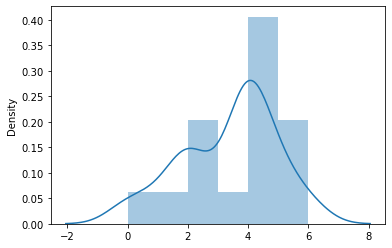

In [ ]:
vocab_size = (len(set(all_words)))  # There are 6655 words in total
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(DF_new['new'])

train_inputs = tokenizer.texts_to_sequences(DF_new['new'])
sns.distplot([len(l) for l in train_inputs])

In [ ]:
A = tokenizer.texts_to_sequences(DF_new['new'])
A = pad_sequences(A, maxlen = len(set(all_words)))
B = np.asarray(DF_new['new'])

print("Number of Samples:", len(A))
print(A[18])
print("Number of Labels: ", len(B))
print(B[18])

Number of Samples: 64
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 6 1 9 1]
Number of Labels:  64
 suckin ball lickin ball 


In [ ]:
Embedding((len(set(all_words))), 32, input_length= len(set(all_words)))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 32, 128)           4096      
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 32, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 591       
Total params: 259,487
Trainable params: 259,487
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# predict probabilities for test set
B_pred = model.predict(A, verbose=0)

In [ ]:
print(B_pred)

[[5.71039319e-01 3.85305732e-01 4.05751914e-02 3.07983253e-03]
 [1.28555885e-02 2.91547719e-02 9.55814660e-01 2.17487407e-03]
 [2.13724241e-01 4.91394615e-03 7.77932763e-01 3.42899584e-03]
 [2.36814027e-03 9.92284358e-01 1.20766566e-03 4.13988763e-03]
 [1.21095516e-02 5.90104004e-03 9.81477737e-01 5.11657679e-04]
 [6.11547530e-01 3.19265336e-01 6.19415157e-02 7.24562351e-03]
 [1.61525968e-03 9.98287022e-01 8.89202693e-06 8.87866772e-05]
 [9.09771979e-01 3.84272053e-03 5.60890064e-02 3.02963331e-02]
 [6.82828575e-02 8.69422019e-01 4.95175533e-02 1.27775790e-02]
 [7.47401834e-01 1.52038112e-01 3.84513773e-02 6.21087141e-02]
 [1.67588741e-01 2.30692893e-01 5.98342180e-01 3.37616284e-03]
 [5.41524105e-02 9.21506047e-01 4.65853326e-03 1.96829364e-02]
 [7.87731171e-01 1.01775557e-01 1.06982008e-01 3.51124885e-03]
 [8.19303840e-03 7.76304456e-04 9.90593731e-01 4.36904113e-04]
 [2.37454325e-02 5.12019217e-01 4.62677151e-01 1.55816076e-03]
 [1.30145426e-03 9.95697498e-01 3.91924914e-05 2.961816

In [ ]:
DF_new.tail(10)

,new
54,catch parkin lot pimpin hittin switch
55,get girl get hoe get motherfuckin bitch
56,get bitch dick everyday
57,suckin ball lickin ball
58,bitch know stick bootyhole
59,ball ball suck ball
60,get bitch dick everyday cmon
61,suckin ball ball lickin ball ball
62,bitch know yeah stick bootyhole
63,ball ball suck ball yeah
